In [1]:
import os,json

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [60]:
IMG_SIZE = 224
BATCH_SIZE = 4
EPOCHS = 100
NUM_KEYPOINTS = 3 * 2

IMG_DIR = "img_train_val"
JSON = "annot.json"
KEYPOINT_DEF = "keypoint_definition.csv"

In [25]:
with open(JSON) as f:
    json_dict = json.load(f)
    #json_data = json.load(f)    
#json_dict = {i["img_path"]: i for i in json_data} # 12538 data
# key:img_path, value:{img_path:str, joints:24*3 list} # keypoint (float x, float y, int isVisible)

In [26]:
keypoint_def = pd.read_csv(KEYPOINT_DEF) # Name, Hex colour
colours = keypoint_def["Hex colour"].to_list()
labels = keypoint_def["Name"].to_list()
keypoint_def

,Index,Name,Hex colour
0,0,up,#ff0000
1,1,mid,#00ff00
2,2,down,#0000ff


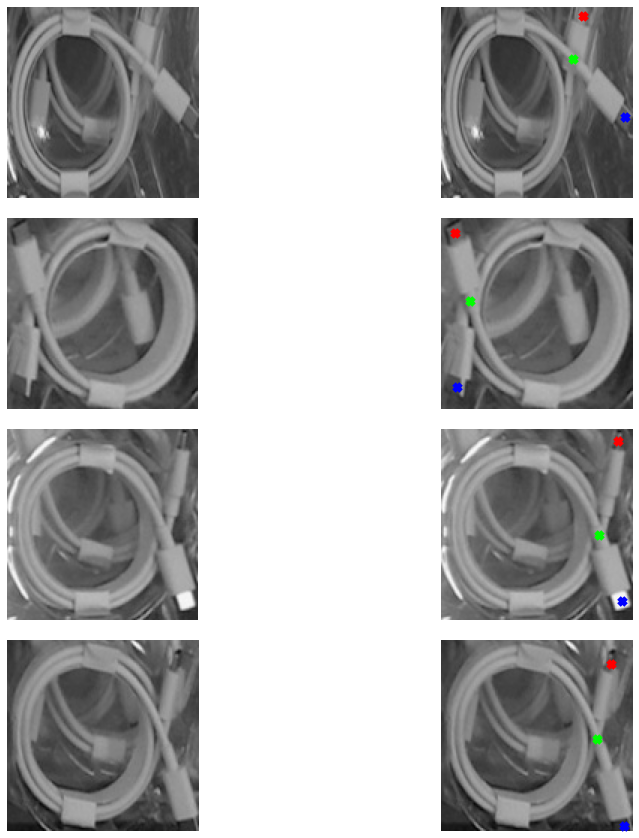

In [38]:
def get_dog(name):
    data = json_dict[name] # key:imgName, value:joints
    img_data = plt.imread(os.path.join(IMG_DIR, name))
    if img_data.shape[-1] == 4: # If the image is RGBA convert it to RGB.
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data
    return data

def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                #print(type(colours[idx]), len(colours[idx]), colours[idx])
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidths=5)

    plt.tight_layout(pad=2.0)
    plt.show()

samples = list(json_dict.keys())
selected_samples = ["20210913-134228_00001_color_5.jpg", "20210914-141235_00001_color_5.jpg", \
    "20210913-134228_00001_color_6.jpg", "20210913-134228_00001_color_4.jpg"]

images, keypoints = [], []
for sample in selected_samples:
    data = get_dog(sample)
    image = data["img_data"]
    keypoint = data["joints"]
    images.append(image)
    keypoints.append(keypoint)
visualize_keypoints(images, keypoints)

In [39]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_dog(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, NUM_KEYPOINTS)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [53]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [54]:
np.random.shuffle(samples) # list[str]
train_keys, validation_keys = samples[int(len(samples) * 0.15) :], samples[: int(len(samples) * 0.15)]
print(len(train_keys), len(validation_keys))

51 9


Total batches in training set: 12
Total batches in validation set: 2
0.0390625
0.9609375


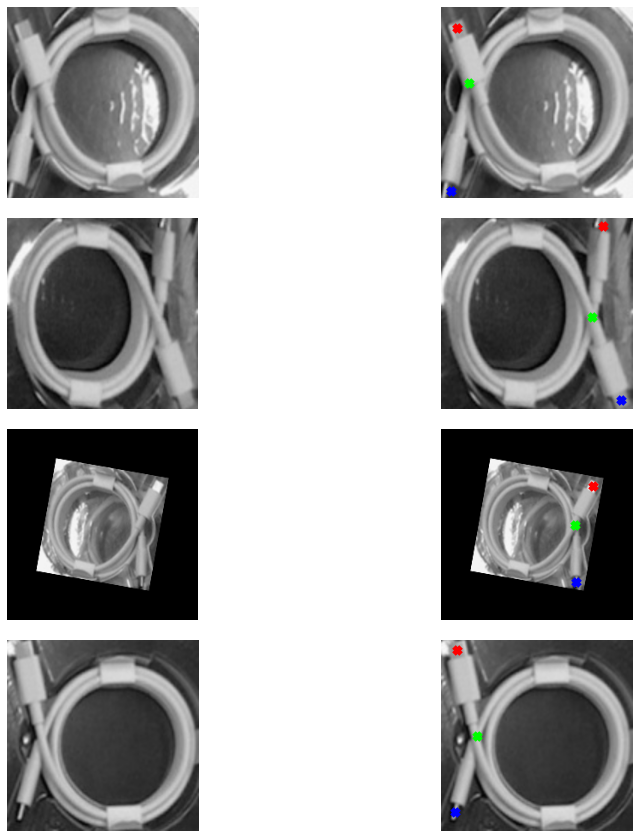

In [55]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
#print(type(sample_images), type(sample_keypoints))
print(sample_keypoints.min())
print(sample_keypoints.max())
#raise
#assert sample_keypoints.max() == 1.0
#assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, NUM_KEYPOINTS//2, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [56]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [61]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 3, 3, 6)           39686     
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 1, 1, 6)     

In [62]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Epoch 1/100
12/12 [==============================] - 1s 86ms/step - loss: 0.1114 - val_loss: 0.1244
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 0.1045 - val_loss: 0.1211
Epoch 3/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0987 - val_loss: 0.1182
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0893 - val_loss: 0.1182
Epoch 5/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0910 - val_loss: 0.1161
Epoch 6/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0998 - val_loss: 0.1117
Epoch 7/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0875 - val_loss: 0.1084
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0837 - val_loss: 0.1065
Epoch 9/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0854 - val_loss: 0.1055
Epoch 10/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0696 - val_loss: 0.1058

12/12 [==============================] - 0s 20ms/step - loss: 0.0169 - val_loss: 0.0312
Epoch 83/100
12/12 [==============================] - 0s 19ms/step - loss: 0.0134 - val_loss: 0.0304
Epoch 84/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0138 - val_loss: 0.0291
Epoch 85/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0125 - val_loss: 0.0275
Epoch 86/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0130 - val_loss: 0.0265
Epoch 87/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0117 - val_loss: 0.0249
Epoch 88/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0101 - val_loss: 0.0240
Epoch 89/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0110 - val_loss: 0.0229
Epoch 90/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0221
Epoch 91/100
12/12 [==============================] - 0s 20ms/step - loss: 0.0118 - val_loss: 0.0215
Epo

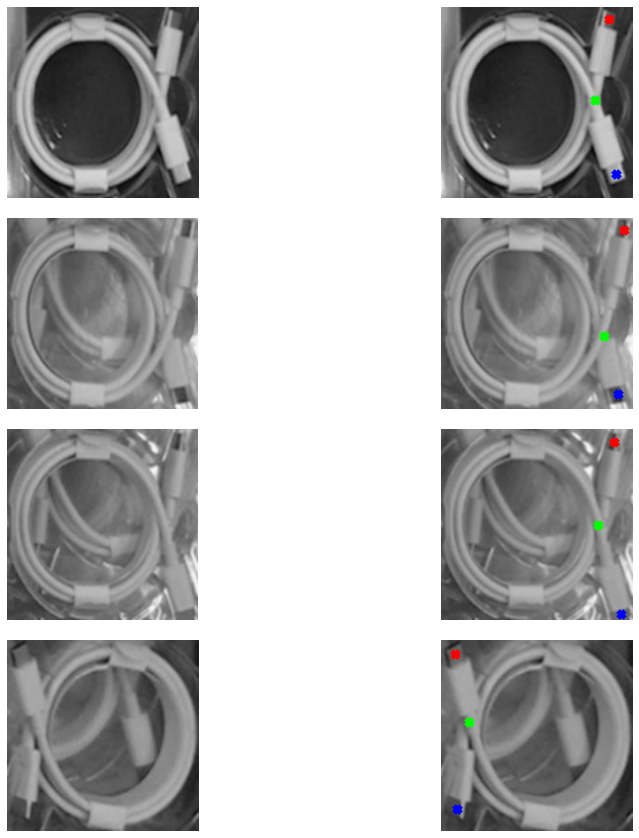

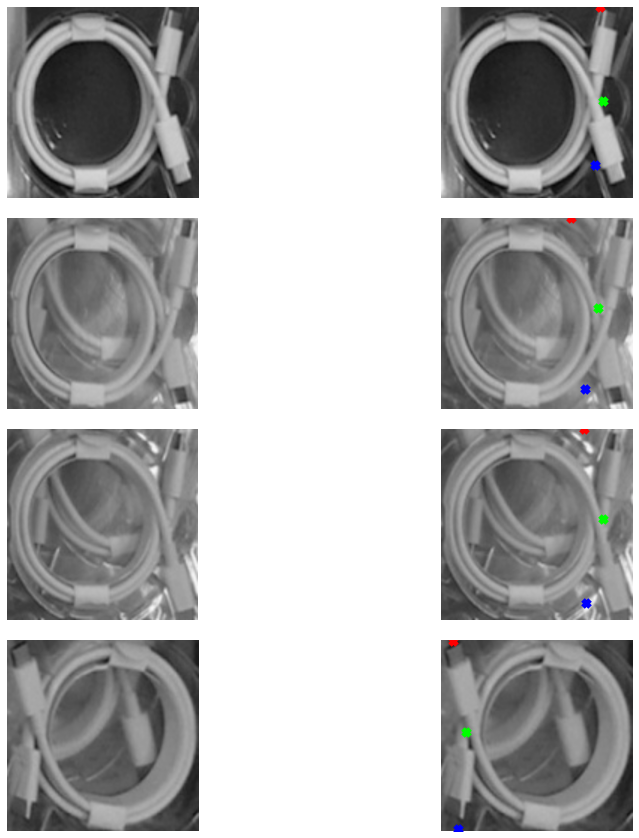

In [63]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, NUM_KEYPOINTS//2, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, NUM_KEYPOINTS//2, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)